In [1]:
import pretty_midi

In [2]:
gt_midi = pretty_midi.PrettyMIDI("/home/jongmin/userdata/piano_transcription/2009_MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV_sliced_60.mid")

In [3]:
import midi_to_pianoroll

In [18]:
gt_parsed = midi_to_pianoroll.parse_midi("/home/jongmin/userdata/piano_transcription/2009_MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV_decoded_midi_60.mid")

In [19]:
gt_pr = midi_to_pianoroll.create_piano_roll(gt_parsed)

In [20]:
import matplotlib.pyplot as plt

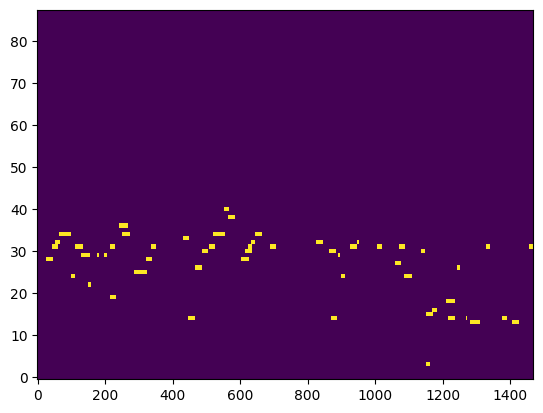

In [21]:
plt.imshow(gt_pr[1], aspect='auto', origin='lower', interpolation='none')

In [24]:
import torch
import torch.nn as nn

In [25]:
class RVQMultiEmbedding(nn.Module):
  def __init__(self, vocab_size=[2048, 2048, 2048, 2048], input_keys = 4, dim=256):
    super().__init__()
    '''
    vocab_size: dict of vocab size for each embedding layer
    is_attention: bool, whether this embedding is made by attention mechanism or not
    input_keys: list of input keys
    '''
    self.vocab_size = vocab_size
    self.d_model = dim
    self.input_keys = input_keys
    self.layers = []
    self._make_emb_layers()

  def _make_emb_layers(self):
    vocab_sizes = [self.vocab_size[key] for key in range(self.input_keys)]
    self.embedding_sizes = [self.d_model for _ in range(self.input_keys)]
    for vocab_size, embedding_size in zip(vocab_sizes, self.embedding_sizes):
      if embedding_size != 0:
        self.layers.append(nn.Embedding(vocab_size, embedding_size))
    self.layers = nn.ModuleList(self.layers)

  def forward(self, x):
    '''
    in case when need to apply different embedding for each input, for example, in case of flattened nb
    x: B x T
    '''
    embeddings = torch.zeros(x.shape[0], x.shape[1], self.d_model).to(x.device)
    emb_list = [module(x[:, (idx+1)%4::4]) for idx, module in enumerate(self.layers)]
    for idx, emb in enumerate(emb_list):
      embeddings[:, (idx+1)%4::4] = emb
    # emb_list = [module(x[:, idx::4]) for idx, module in enumerate(self.layers)]
    # for idx, emb in enumerate(emb_list):
    #   embeddings[:, idx::4] = emb
    return embeddings
  
  def get_emb_by_key(self, key:str, token:torch.Tensor):
    '''
    key: key of musical info
    token: B x T (idx of musical info)
    '''
    layer_idx = self.input_keys.index(key)
    return self.layers[layer_idx](token)

class SummationEmbedder(RVQMultiEmbedding):
  def __init__(self, vocab_size, input_keys, dim):
    super().__init__(vocab_size, input_keys, dim)

  def forward(self, x):
    '''
    x: B x T x num_musical_info(4)
    '''
    if isinstance(x, torch.Tensor): # input embedder
      emb_list = [module(x[..., i]) for i, module in enumerate(self.layers)]
    elif isinstance(x, list): # double-sequential decoder embedder
      emb_list = x
    stacked_emb = torch.stack(emb_list, dim=2) # B x T x num_musical_info(7, in case cp) x emb_size
    # sum
    output = torch.sum(stacked_emb, dim=2) # B x T x emb_size
    return output

In [70]:
class SemCodecMidiDecoder(nn.Module):
  def __init__(self, in_channels=256, out_channels=88, kernel_size=3, stride=1, padding=1):
      super().__init__()
      self.out_channels = out_channels
      self.emb = SummationEmbedder(vocab_size=[2048, 2048, 2048, 2048], input_keys = 4, dim=in_channels)
      self.layers = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=256, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Conv1d(in_channels=512, out_channels=out_channels*2, kernel_size=kernel_size, stride=1, padding=1),
        )
      self.rnn = nn.GRU(input_size=out_channels*2, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
      self.proj = nn.Linear(128*2, out_channels*2)
      self.act = nn.Sigmoid()
  
  def forward(self, x):
      x = self.emb(x.permute(0,2,1))
      x = self.layers(x.permute(0,2,1))
      x = self.rnn(x.permute(0,2,1))[0]
      x = self.proj(x)
      x = self.act(x.permute(0,2,1))
      x = torch.stack([x[:,:88,:],x[:,88:,:]], dim=1)
      return x

In [71]:
model = SemCodecMidiDecoder()

In [32]:
tokens = torch.load("/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_encodec.pt")

In [72]:
out = model(tokens[30])
out.shape

torch.Size([1, 2, 88, 1500])

In [35]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [36]:
get_n_params(model)

2958384

In [39]:
for i in model.named_parameters():
    print(i)

('emb.layers.0.weight', Parameter containing:
tensor([[ 0.5261,  0.5373, -0.5717,  ...,  1.9620,  1.2971, -0.2561],
        [ 0.7505, -0.6816, -1.1045,  ...,  1.5092, -1.0601,  1.2384],
        [-0.9731,  0.0161, -0.1394,  ...,  1.4815, -1.8172,  0.7377],
        ...,
        [ 0.0419, -0.7705,  1.0540,  ..., -0.0973,  0.9532,  0.2626],
        [ 0.9399, -0.0770, -0.0849,  ..., -0.0166, -0.1611, -0.2939],
        [-1.0190, -0.4221,  0.3608,  ..., -0.8843, -2.0362,  0.3779]],
       requires_grad=True))
('emb.layers.1.weight', Parameter containing:
tensor([[ 0.0485,  1.3202,  0.8648,  ..., -0.2931, -0.1628,  1.5716],
        [-1.3444, -1.1491, -0.2691,  ...,  0.9304, -1.2728, -0.9987],
        [ 2.4219,  1.4501,  0.8980,  ...,  0.5627,  0.5381, -0.1427],
        ...,
        [-0.8296, -0.9093, -0.1558,  ..., -1.3273,  0.1121,  0.7805],
        [-0.7876,  0.4470, -0.1390,  ..., -0.5355, -1.2454, -0.5735],
        [ 0.0974, -1.0129,  0.2260,  ..., -0.3811, -0.8954,  0.1589]],
       requi

In [73]:
from audiocraft.losses.note_eval import extract_notes

In [74]:
from audiocraft.data.midi_dataset import EnCodecTokenMIDIDataset
from torch.utils.data import DataLoader

In [77]:

loaded = torch.load('/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/maestro-v3.0.0_split.pt')
validation_list = loaded["validation"]

path = '/home/jongmin/userdata/MAESTRO/maestro-v3.0.0'
validset = EnCodecTokenMIDIDataset(validation_list)

val_loader = DataLoader(validset, batch_size=64, shuffle=True)

  4%|▍         | 6/137 [00:00<00:03, 37.61it/s]

Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_03_Track03_wav--1.midi
39 38
Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_03_Track03_wav.midi
12 11


 10%|█         | 14/137 [00:00<00:04, 28.09it/s]

Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_11_R1_2004_03-04_ORIG_MID--AUDIO_11_R1_2004_04_Track04_wav.midi
20 19


 35%|███▌      | 48/137 [00:01<00:02, 31.54it/s]

Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2008/MIDI-Unprocessed_15_R2_2008_01-04_ORIG_MID--AUDIO_15_R2_2008_wav--4.midi
22 21


 55%|█████▍    | 75/137 [00:02<00:01, 33.96it/s]

Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2011/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_15_Track15_wav.midi
13 12


 72%|███████▏  | 98/137 [00:03<00:01, 24.66it/s]

Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--2.midi
11 10
Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--4.midi
19 18


100%|██████████| 137/137 [00:05<00:00, 26.02it/s]

Length mismatch! Popping -2 index
/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2018/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--4.midi
10 9


In [92]:
validset[0][1][1].shape

torch.Size([88, 1500])

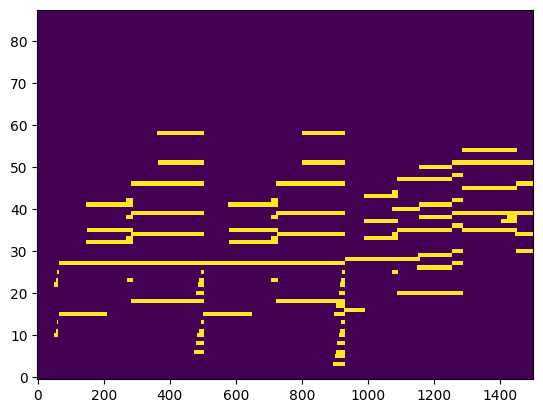

In [93]:
plt.imshow(validset[0][1][1], aspect='auto', origin='lower', interpolation='none')

In [85]:

model.eval()
model.cuda()
with torch.no_grad():
    encodec_tensor, pr_tensor = validset[0]
    encodec_tensor = encodec_tensor.to("cuda")
    pr_tensor = pr_tensor.to("cuda")
    print(pr_tensor.shape)
    output = model(encodec_tensor.unsqueeze(0))
    prediction = output.round()
    print(prediction.shape)
    pred_notes = extract_notes(prediction[0,0].T, prediction[0,1].T, None)
    pred_midi = pretty_midi.PrettyMIDI()
    pred_midi.instruments.append(pretty_midi.Instrument(0))
    for i, pitch in enumerate(pred_notes[0]):
        pred_midi.instruments[0].notes.append(pretty_midi.Note(
            velocity=100,
            pitch=pitch,
            start=pred_notes[1][i,0]/50,
            end=pred_notes[1][i,1]/50
        ))
    pred_wav = pred_midi.synthesize()
    print(pred_wav.shape)
    # wandb.log({"val_inference/wav": wandb.Audio(pred_wav, caption=f"pred_wav_{epoch}", sample_rate=44100)})

torch.Size([2, 88, 1500])
torch.Size([1, 2, 88, 1500])


(1367100,)
